In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import time

En este notebook lo que vamos a hacer es crear un clasificador sobre el dataset del MNIST para prácticar como introducción a PyTorch.

# Carga del dataset

Hay muchos datasets incluídos dentro de ```torchvision.datasets```, así que resulta fácil cargarlos. Todos se implementan como subclases de ```torch.utils.data.Dataset```, así que se pueden pasar a un ```torch.utils.data.DataLoader```. Por defecto el dataset lo carga como imágenes en formato ```PIL``` así que tenemos que aplicarle una transformación para convertirlo en tensores.

In [2]:
mnist_train = torchvision.datasets.MNIST(root = "/MNIST", download = True, train = True, transform = torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root = "/MNIST", download = True, train = False, transform = torchvision.transforms.ToTensor())
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /MNIST
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /MNIST
     Split: Test
     StandardTransform
 Transform: ToTensor())

Ahora que hemos cargado el dataset tenemos que meterlo en un ```DataLoader``` para poder pasarselo cómodamente a los modelos. Lo que hace es combinar un dataset y un sampler y nos permite iterar sobre el dataset.

In [3]:
train = torch.utils.data.DataLoader(mnist_train, batch_size = 64, shuffle = True)
test = torch.utils.data.DataLoader(mnist_test, batch_size = 64, shuffle = True)
train, test

(<torch.utils.data.dataloader.DataLoader at 0x2161f2399a0>,
 <torch.utils.data.dataloader.DataLoader at 0x2161f239940>)

Una vez hemos creado el ```DataLoader``` podemos iterar sobre él y nos devuelve los elementos del dataset en los batches que hemos especificado. Es importante recordar que al iterar nos devuelve dos tensores, el X y el Y agrupados en una lista.

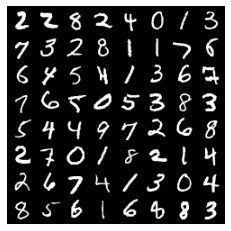

In [4]:
for X, Y in train:
    grid = torchvision.utils.make_grid(X, nrow = int(np.sqrt(len(X))))
    plt.imshow(grid.permute(1,2,0)) #Hay que permutar porque matplotlib espera los canales al final y torch los pone al principio
    plt.axis('off')
    plt.show()
    break

# Creando el primer modelo

La forma típica de trabajar con PyTorch es heredando de la clase ```torch.nn.Module```, pero también tienen una clase ```torch.nn.Sequential``` que funciona de forma muy similar a TF/Keras, así que vamos a empezar probando eso y luego ya lo hacemos con subclassing:

In [5]:
for X, Y in train:
    print(X.shape)
    break

torch.Size([64, 1, 28, 28])


In [4]:
architecture = [
    nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3),
    nn.MaxPool2d(kernel_size = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
    nn.MaxPool2d(kernel_size = 2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
    nn.Softmax()
]

In [5]:
model = nn.Sequential(*architecture)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=None)
)


In [9]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.max(axis = -1)[-1]
    div = y_true / y_pred
    res = np.where(div == 1, 1, 0)
    return res.sum() / len(y_true)

## Training Loop

In [11]:
epochs = 5
losses = []
acc = []

time_i = time.time()

for epoch in range(epochs):
    for X, Y in train:
        pred = model(X)
        loss = loss_fn(pred, Y)

        #Calculamos los gradientes
        loss.backward()

        #Actualizamos los pesos con el optimizador
        optim.step()

        #Volvemos a hacer 0 los gradientes para que no se acumulen
        optim.zero_grad()

    #Guardamos el error y la precisión después de cada época
    losses.append(loss)
    acc.append(accuracy(Y, pred))

print(f"Tiempo total de entrenamiento: {time.time() - time_i }s.")

Tiempo total de entrenamiento: 233.76529049873352s.


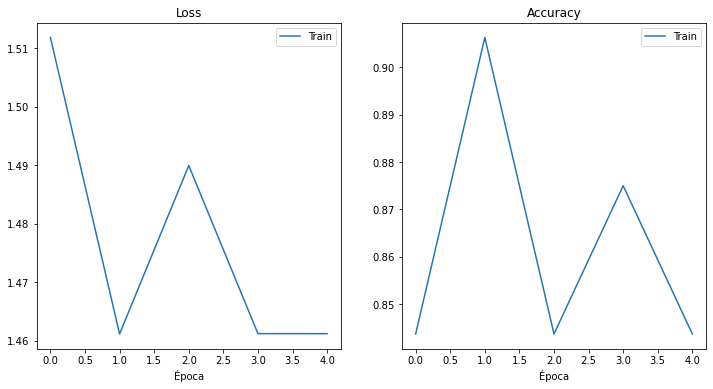

In [12]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(acc, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()

## Ahora en GPU
La única diferencia es que hay que mover el modelo y el dataset a la GPU. Como estamos usando un ```DataLoader```, no podemos moverlo directamente a la GPU si no que iremos moviendo los batches progresivamente. Lo primero que hay que hacer es localizar nuestra GPU:

In [6]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Elige GPU si está disponible y CPU si no
device

device(type='cuda', index=0)

In [18]:
model = nn.Sequential(*architecture)
model.to(device) #Hay que moverlo a la GPU antes de crear el optimizador, porque el optimizador tiene como input lo parámetros del modelo
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=None)
)


In [19]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [27]:
 """Está mal porque al hacer la división, las etiquetas que son 0 nos dan un NaN, 
 que no se cuenta al hacer el where la de abajo está mucho mejor porque comprueba directamente elemento a elemento
 """
def accuracy_mal(y_true, y_pred): 
    y_pred = y_pred.argmax(axis = -1)
    div = y_true / y_pred
    return torch.sum(torch.where(div == 1, 1, 0))/len(y_pred)

In [20]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.argmax(axis = -1)
    return torch.sum(y_pred == y_true) / len(y_pred)

In [17]:
train_iter = iter(train)

In [18]:
x_test, y_test = train_iter.next()

In [21]:
epochs = 30
losses = []
accs = []

time_i = time.time()

for epoch in range(epochs):
    loss_epoch = []
    accs_epoch = []
    for X, Y in train:
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss = loss_fn(pred, Y)

        #Calculamos los gradientes
        loss.backward()

        #Actualizamos los pesos con el optimizador
        optim.step()

        #Volvemos a hacer 0 los gradientes para que no se acumulen
        optim.zero_grad()

        #Guardamos el error y la precisión después de cada batch
        loss_epoch.append(loss)
        accs_epoch.append(accuracy(Y, pred))
        
    #Y los guardamos finalmente por época
    losses.append(torch.mean(torch.Tensor(loss_epoch)))
    accs.append(torch.mean(torch.Tensor(accs_epoch)))
    #Printeamos para ir viendo cómo va
    print(f"Época {epoch+1} -> Loss: {losses[-1]} / Accuracy: {accs[-1]}")
print(f"Tiempo total de entrenamiento: {time.time() - time_i} s.")

Época 1 -> Loss: 1.4657151699066162 / Accuracy: 0.9954357743263245
Época 2 -> Loss: 1.4662331342697144 / Accuracy: 0.9949193596839905
Época 3 -> Loss: 1.4661483764648438 / Accuracy: 0.9949360489845276
Época 4 -> Loss: 1.4659528732299805 / Accuracy: 0.995185911655426
Época 5 -> Loss: 1.466463565826416 / Accuracy: 0.9946528673171997
Época 6 -> Loss: 1.4654796123504639 / Accuracy: 0.9956356883049011
Época 7 -> Loss: 1.4659028053283691 / Accuracy: 0.9952358603477478
Época 8 -> Loss: 1.4667773246765137 / Accuracy: 0.9943529963493347
Época 9 -> Loss: 1.4672679901123047 / Accuracy: 0.9937700033187866
Época 10 -> Loss: 1.4654853343963623 / Accuracy: 0.995618999004364
Época 11 -> Loss: 1.4664539098739624 / Accuracy: 0.9946195483207703
Época 12 -> Loss: 1.4660394191741943 / Accuracy: 0.9950859546661377
Época 13 -> Loss: 1.46522855758667 / Accuracy: 0.9959021806716919
Época 14 -> Loss: 1.4655920267105103 / Accuracy: 0.9954857230186462
Época 15 -> Loss: 1.4660741090774536 / Accuracy: 0.99508595466

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(accs, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()

# Repetimos usando herencia

In [12]:
class classifierMNIST(nn.Module):
    def __init__(self, conv_layers, linear_layers, channel_in, input_dim, classes, kernel_size = 3):
        super(classifierMNIST, self).__init__()


        self.flatten_dim = self.__calculate_flatten_dim(input_dim, conv_layers, kernel_size)
        conv_layers.insert(0, channel_in)
        self.conv = nn.ModuleList([nn.Conv2d(in_channels = dim_in, out_channels = dim_out, kernel_size = kernel_size) for dim_in, dim_out in zip(conv_layers, conv_layers[1:])])

        
        linear_layers.insert(0, self.flatten_dim)
        self.linear = nn.ModuleList([nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(linear_layers, linear_layers[1:])])

        self.final = nn.Linear(linear_layers[-1], classes)

    def __calculate_flatten_dim(self, input_dim, conv_layers, kernel_size):
        flatten_input_dim = input_dim
        
        for _ in conv_layers:
            #Le quitamos las dimensiones de las convolucionales(kernel - 1)
            flatten_input_dim -= kernel_size - 1
            #Dividimos por las dimensiones del max pooling
            flatten_input_dim = int(flatten_input_dim / 2)

        return flatten_input_dim ** 2 * conv_layers[-1]

    def forward(self, x):
        pred = x #Esto lo hacemos para que pueda ser todo recursivo
        #Hacemos el paso por todas las convolucionales
        for layer in self.conv:
            pred = layer(pred)
            pred = nn.ReLU()(pred)
            pred = nn.MaxPool2d(kernel_size=2)(pred)
            # print("Conv hecha")
        #Hacemos flatten
        pred = nn.Flatten()(pred)
        # print(f"Flatten hecho -> {pred.shape}")
        #Hacemos el paso por las lineales menos la última
        for layer in self.linear:
            pred = layer(pred)
            pred = nn.ReLU()(pred)
            # print("Linear hecha")
        #Llegamos a la capa final y aplicamos la softmax
        pred = self.final(pred)
        pred = nn.Softmax()(pred)
        # print("Paso entero completado")

        return pred

In [14]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Elige GPU si está disponible y CPU si no
device

device(type='cuda', index=0)

In [15]:
model = classifierMNIST(conv_layers = [32, 64], linear_layers = [512], channel_in = 1, input_dim = 28, classes = 10, kernel_size = 3)

In [16]:
model.to(device)

classifierMNIST(
  (conv): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (linear): ModuleList(
    (0): Linear(in_features=1600, out_features=512, bias=True)
  )
  (final): Linear(in_features=512, out_features=10, bias=True)
)

In [17]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
epochs = 30
losses = []
losses_val = []
accs = []
accs_val = []

time_i = time.time()

for epoch in range(epochs):
    loss_epoch = []
    accs_epoch = []
    loss_epoch_val = []
    accs_epoch_val = []
    for (X, Y), (X_val, Y_val) in zip(train, test):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss = loss_fn(pred, Y)

        #Calculamos los gradientes
        loss.backward()

        #Actualizamos los pesos con el optimizador
        optim.step()

        #Volvemos a hacer 0 los gradientes para que no se acumulen
        optim.zero_grad()

        #Guardamos el error y la precisión después de cada batch
        loss_epoch.append(loss)
        accs_epoch.append(accuracy(Y, pred))

        #Evaluamos sobre el dataset de validación
        with torch.no_grad():
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            pred_val = model(X_val)
            loss_val = loss_fn(pred_val, Y_val)

            loss_epoch_val.append(loss_val)
            accs_epoch_val.append(accuracy(Y_val, pred_val))

    #Y los guardamos finalmente por época
    losses.append(torch.mean(torch.Tensor(loss_epoch)))
    accs.append(torch.mean(torch.Tensor(accs_epoch)))

    losses_val.append(torch.mean(torch.Tensor(loss_epoch_val)))
    accs_val.append(torch.mean(torch.Tensor(accs_epoch_val)))

    #Printeamos para ir viendo cómo va
    print(f"Época {epoch+1} -> (Train) Loss: {losses[-1]} / Accuracy: {accs[-1]} || (Validation) Loss: {losses_val[-1]} / Accuracy: {accs_val[-1]}")
print(f"Tiempo total de entrenamiento: {time.time() - time_i} s.")

Época 1 -> (Train) Loss: 1.7571179866790771 / Accuracy: 0.6243033409118652 || (Validation) Loss: 1.7463091611862183 / Accuracy: 0.6326631903648376
Época 2 -> (Train) Loss: 1.582782506942749 / Accuracy: 0.7816480994224548 || (Validation) Loss: 1.5748225450515747 / Accuracy: 0.7929936051368713
Época 3 -> (Train) Loss: 1.5024827718734741 / Accuracy: 0.8658439517021179 || (Validation) Loss: 1.4999852180480957 / Accuracy: 0.8670381903648376
Época 4 -> (Train) Loss: 1.4936347007751465 / Accuracy: 0.8730095624923706 || (Validation) Loss: 1.4966840744018555 / Accuracy: 0.8692277073860168
Época 5 -> (Train) Loss: 1.49288809299469 / Accuracy: 0.8738057613372803 || (Validation) Loss: 1.4916781187057495 / Accuracy: 0.8749004602432251
Época 6 -> (Train) Loss: 1.4894849061965942 / Accuracy: 0.8754976391792297 || (Validation) Loss: 1.488290786743164 / Accuracy: 0.8779856562614441
Época 7 -> (Train) Loss: 1.4880048036575317 / Accuracy: 0.878085196018219 || (Validation) Loss: 1.4851340055465698 / Accur

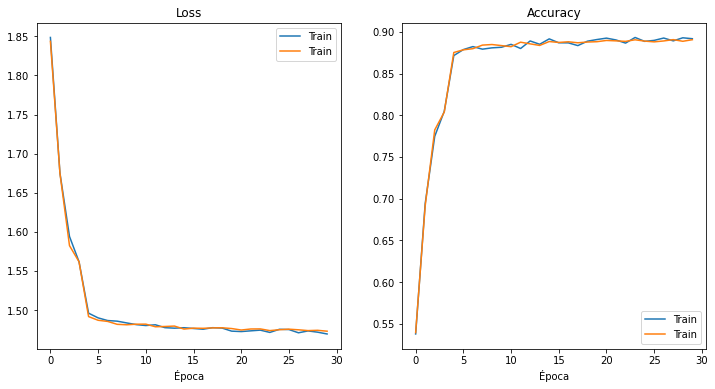

In [40]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses, label = "Train")
plt.plot(losses_val, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(accs, label = "Train")
plt.plot(accs_val, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()

# TensorFlow

In [19]:
import tensorflow as tf

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [21]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = 3, input_shape = (28,28,1), activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, kernel_size = 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               819712    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 1e-8), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

In [24]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 30, validation_data = (x_test, y_test))

Epoch 1/30
938/938 [==============================] - 4s 4ms/step - loss: 0.1399 - accuracy: 0.9568 - val_loss: 0.0503 - val_accuracy: 0.9832
Epoch 2/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0449 - accuracy: 0.9861 - val_loss: 0.0361 - val_accuracy: 0.9880
Epoch 3/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0550 - val_accuracy: 0.9828
Epoch 4/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0343 - val_accuracy: 0.9885
Epoch 5/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0397 - val_accuracy: 0.9876
Epoch 6/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0368 - val_accuracy: 0.9893
Epoch 7/30
938/938 [==============================] - 3s 3ms/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0310 - val_accuracy: 0.9904
Epoch 

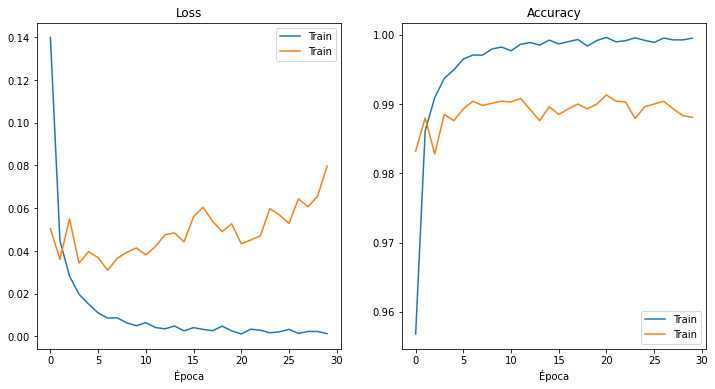

In [25]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()